# Airbnb Pricing Optimization



![](https://bmtoolbox.net/wp-content/uploads/2016/06/airbnb.jpg)

> Airbnb claims to be part of the "sharing economy" and disrupting the hotel industry. However, data shows that the majority of Airbnb listings in most cities are entire homes, many of which are rented all year round - disrupting housing and communities.

![](http://insideairbnb.com/images/insideairbnb_graphic_site_1200px.png)

## Aims and Objectives

- EDA
  - Locations
  - Renters
  - Hosts
- Pricing Optimisation
  - Property Price
  - Investment Portfolio

## Imports

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
plt.style.use('seaborn')

## Extract Data

**1 Year properties listing from San Francisco on Airbnb**

![](https://i.insider.com/5dc487757eece55ce94a2192?width=900&format=jpeg&auto=webp)

In [26]:
urls = [
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-06-08/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-05-06/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-04-07/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-03-13/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-02-12/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-01-04/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2020-01-02/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2019-12-04/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2019-11-01/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2019-10-14/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2019-09-12/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2019-08-06/data/listings.csv',
        'http://data.insideairbnb.com/united-states/ca/san-francisco/2019-07-08/data/listings.csv'
]
dfs = pd.concat([pd.read_csv(x) for x in urls],ignore_index=True)
dfs['availability'] = dfs['availability_365'] / 365
# dfs['date'] = pd.to_datetime(dfs['last_scraped'])
# dfs['dayofweek'] = dfs['date'].dt.dayofweek
# dfs['quarter'] = dfs['date'].dt.quarter
# dfs['month'] = dfs['date'].dt.month
# dfs['year'] = dfs['date'].dt.year
# dfs['dayofyear'] = dfs['date'].dt.dayofyear
# dfs['dayofmonth'] = dfs['date'].dt.day
# dfs['weekofyear'] = dfs['date'].dt.weekofyear

# time_columns = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']

# clean price
for x in ['price','weekly_price','monthly_price','security_deposit','cleaning_fee']:
  dfs[x] = dfs[x].str.replace('$','').str.replace(',','').astype(float).fillna(0)
dfs[:1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability
0,958,https://www.airbnb.com/rooms/958,20200608144408,2020-06-08,"Bright, Modern Garden Unit - 1BR/1BTH",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,* No Pets - even visiting guests for a short t...,NaN,NaN,https://a0.muscache.com/im/pictures/b7c2a199-4...,NaN,1169,https://www.airbnb.com/users/show/1169,Holly,2008-07-31,"San Francisco, California, United States",We are a family with 2 boys born in 2009 and 2...,within an hour,100%,99%,t,https://a0.muscache.com/im/pictures/user/efdad...,https://a0.muscache.com/im/pictures/user/efdad...,Duboce Triangle,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Duboce Triangle,Western Addition,...,1,1125,1,1,1125,1125,1.0,1125.0,5 weeks ago,t,8,24,43,143,2020-06-08,241,47,2009-07-23,2020-03-28,97.0,10.0,10.0,10.0,10.0,10.0,10.0,t,STR-0001256,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1,0,0,1.82,0.391781


**Latest Month**

In [27]:
df = dfs[dfs.last_scraped == '2020-06-08'].copy()
# save a list of columns before filtering
all_columns = df.columns.tolist()

selected_columns = ['id','last_scraped','listing_url','host_id','property_type','zipcode','accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price','monthly_price', 'security_deposit', 'cleaning_fee','number_of_reviews','review_scores_rating','cancellation_policy','neighbourhood','availability_365','latitude','longitude']
# filter columns
df = df[selected_columns]

df[:1]

,id,last_scraped,listing_url,host_id,property_type,zipcode,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,cancellation_policy,neighbourhood,availability_365,latitude,longitude
0,958,2020-06-08,https://www.airbnb.com/rooms/958,1169,Apartment,94117,3,1.0,1.0,2.0,170.0,1120.0,4200.0,100.0,100.0,241,97.0,moderate,Duboce Triangle,143,37.76931,-122.43386


##EDA

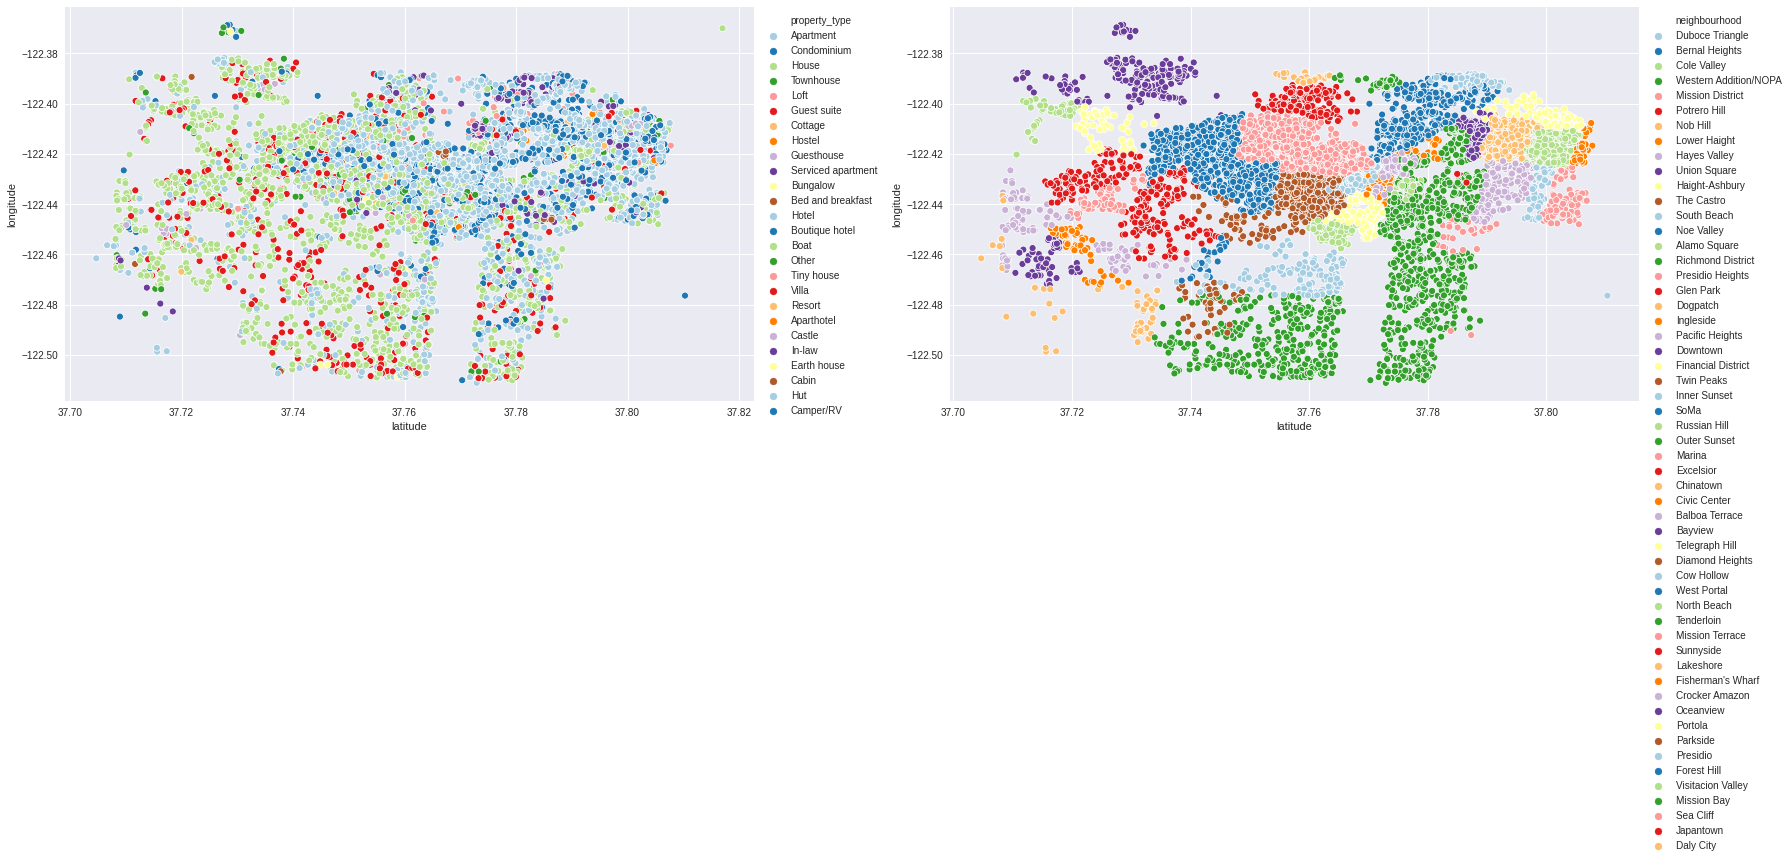

In [28]:
fig,ax = plt.subplots(1,2,figsize=(25,10))

sns.scatterplot(data=df,x='latitude',y='longitude',hue='property_type',palette=sns.color_palette("Paired", df.property_type.nunique()),ax=ax.ravel()[0])

sns.scatterplot(data=df,x='latitude',y='longitude',hue='neighbourhood',palette=sns.color_palette("Paired", df.neighbourhood.nunique()),ax=ax.ravel()[1])

ax.ravel()[0].legend(bbox_to_anchor=(1.0,1.0))
ax.ravel()[1].legend(bbox_to_anchor=(1.0,1.0))
plt.tight_layout()

**Diversity and Dominance**

In [29]:
def shannon(series):
  """
  series: pd.Series
  """
  
  N = series.sum()
  
  s = np.array([ (n/N) * np.log(n/N) for n in series if n != 0])
  
  s = s[~np.isnan(s)]
  
  return np.abs(s.sum())

def simpson(series):
  """
  series: pd.Series
  """
  
  N = series.sum()
  
  return np.array([ ( n * (n-1) ) / ( N * (N-1) ) for n in series if n != 0]).sum()

**Diversity and Dominance of property types by neighbourhood**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


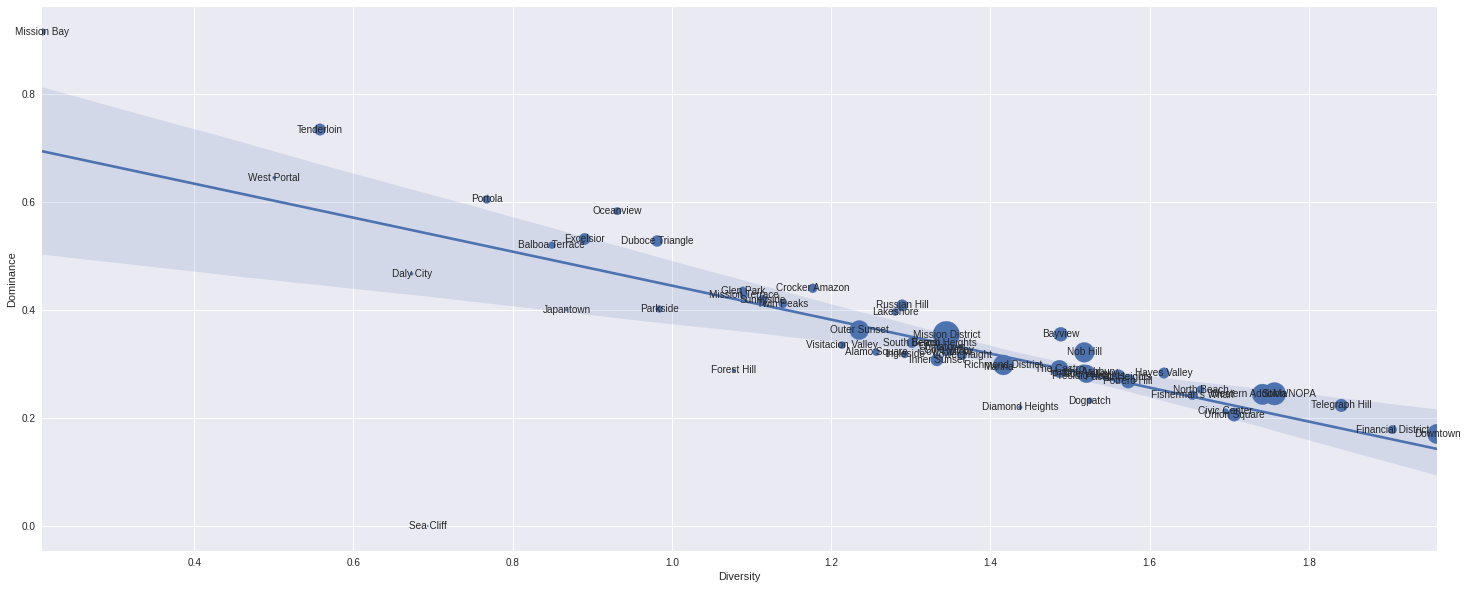

In [30]:
plt.figure(figsize=(25,10))
ngh = pd.crosstab(df.property_type,df.neighbourhood)
ngh_diversity = ngh.apply(shannon)
ngh_dominance = ngh.apply(simpson)
ngh_df = pd.DataFrame({
    'diversity': ngh_diversity,
    'dominance': ngh_dominance,
    'total_number_of_properties': ngh.sum(),
    'unique_property_types': df.groupby('neighbourhood').property_type.nunique()
    
}).reset_index()

plt.scatter(ngh_diversity,ngh_dominance,s=ngh.sum(),label='Property Type',cmap='Oranges')
sns.regplot(ngh_diversity,ngh_dominance,scatter=False)

for i,x in enumerate(ngh.columns):
  plt.annotate(x,(ngh_diversity[i],ngh_dominance[i]),ha='center',va='center')

plt.xlabel('Diversity')
plt.ylabel('Dominance');

In [31]:
ngh_df[ngh_df.neighbourhood.isin(['Downtown','Mission District','Mission Bay'])]

,neighbourhood,diversity,dominance,total_number_of_properties,unique_property_types
12,Downtown,1.961264,0.170480,382,12
27,Mission Bay,0.208982,0.914010,46,3
28,Mission District,1.344584,0.354231,705,11


***Diversity and Dominance of property types by for each neighbourhood***

- Downtown - the most diverse, balanced property distribution in terms of price
- Mission District - quite diverse, large number of properties
- Mission Bay - low number of properties, and focused on few types





**Property Distributions**

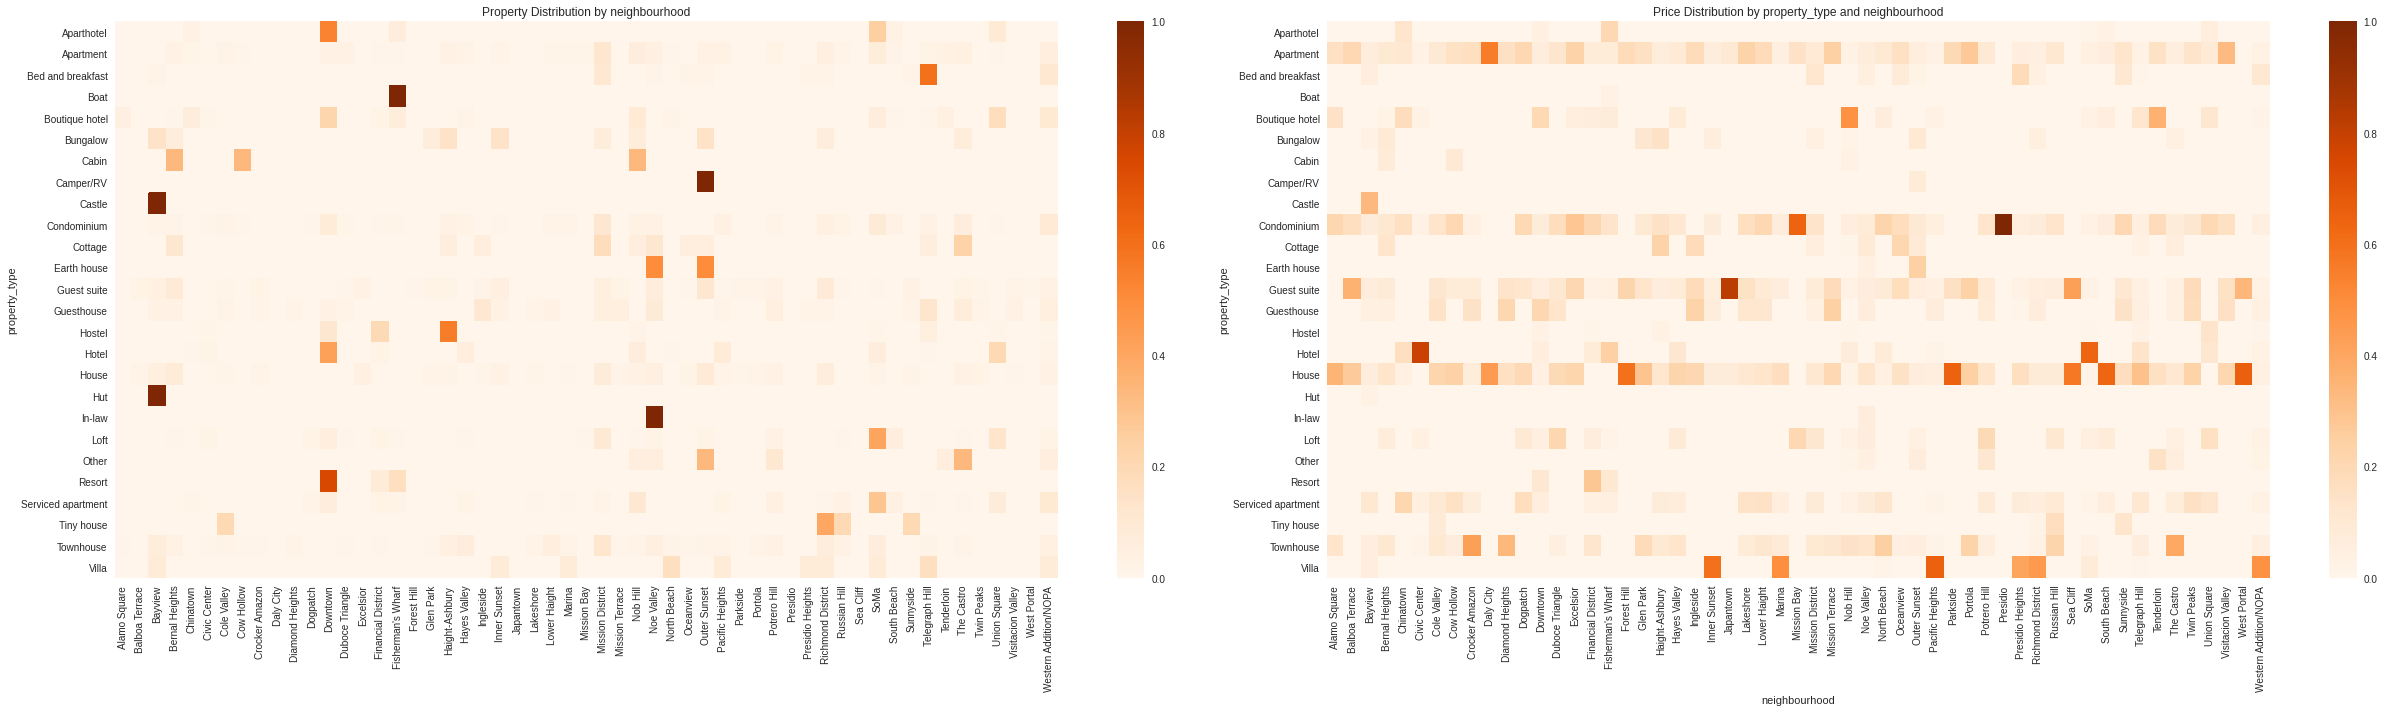

In [32]:
fig,ax = plt.subplots(1,2,figsize=(35,10))

property_distribution = df.pivot_table(index='neighbourhood',columns='property_type',values='id',aggfunc='count',fill_value=0).T
property_distribution = property_distribution.apply(lambda x: x / x.sum(),axis=1)
sns.heatmap(property_distribution,ax=ax.ravel()[0],cmap='Oranges')

property_price = df.pivot_table(index='neighbourhood',columns='property_type',values='price',aggfunc='mean',fill_value=0)
property_price = property_price.apply(lambda x: x / x.sum(),axis=1)
sns.heatmap(property_price.T,ax=ax.ravel()[1],cmap='Oranges')

ax.ravel()[0].set_xlabel('')
# ax.ravel()[0].set_xticklabels([''])
ax.ravel()[0].set_title('Property Distribution by neighbourhood')
ax.ravel()[1].set_title('Price Distribution by property_type and neighbourhood')
plt.tight_layout()

Outliers:
 - Bayview:
  - Castle
  - Hut
 - Fisherman's Wharf:
  - Boat
 - Nob Hill:
  - In-law
 - Outer Susnet
  - Camper

**Average Yearly Availability by Property Type**

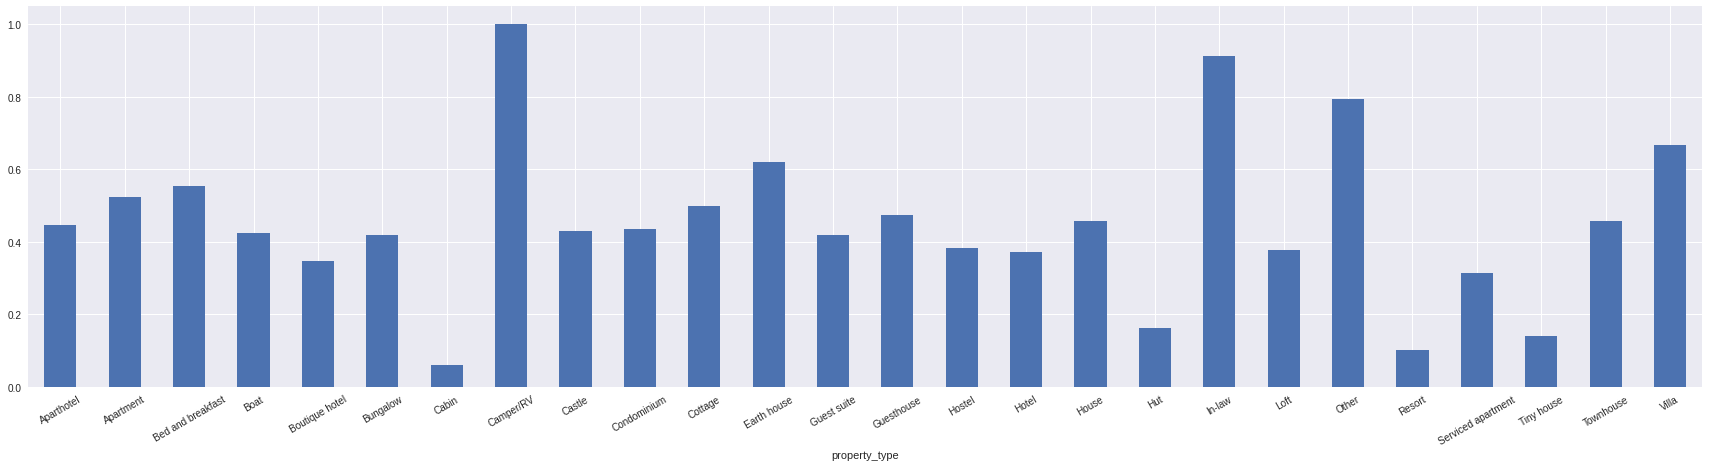

In [33]:
(df.groupby('property_type').availability_365.mean() / 365).plot.bar(rot=30,figsize=(30,7))

**Average Yearly Availability by Neighbourhood**

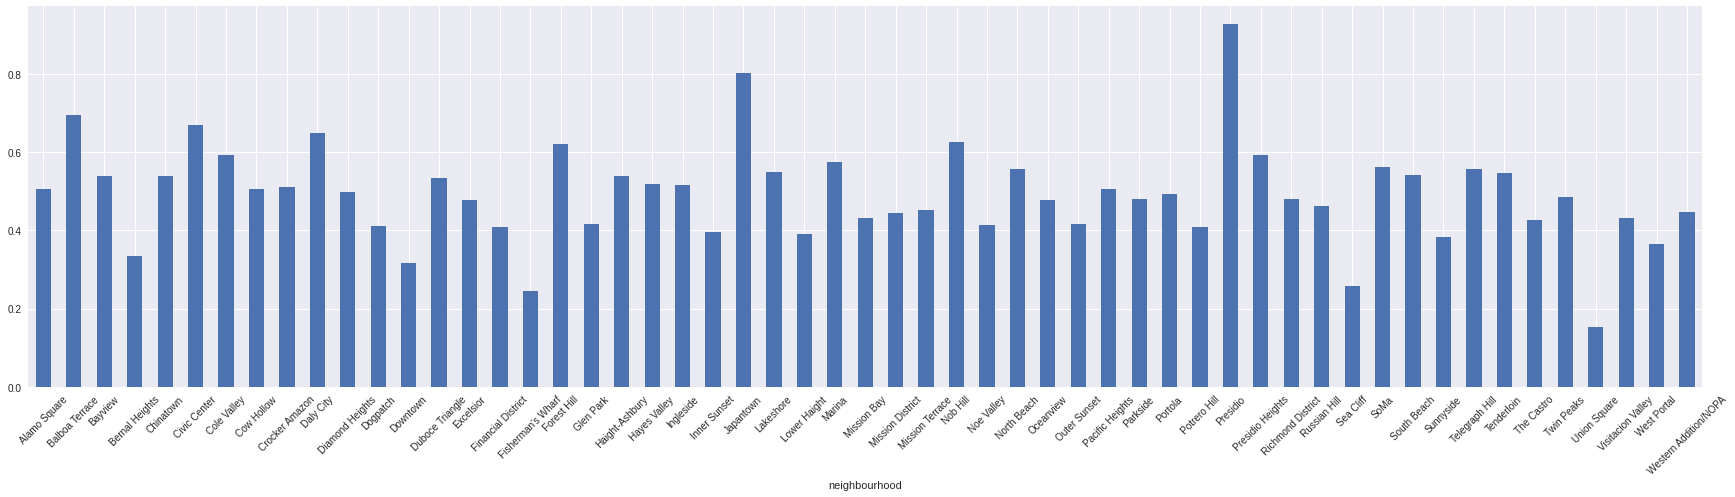

In [34]:
(df.groupby('neighbourhood').availability_365.mean() / 365).plot.bar(rot=45,figsize=(30,7))

**Number of hosts by range of properties**

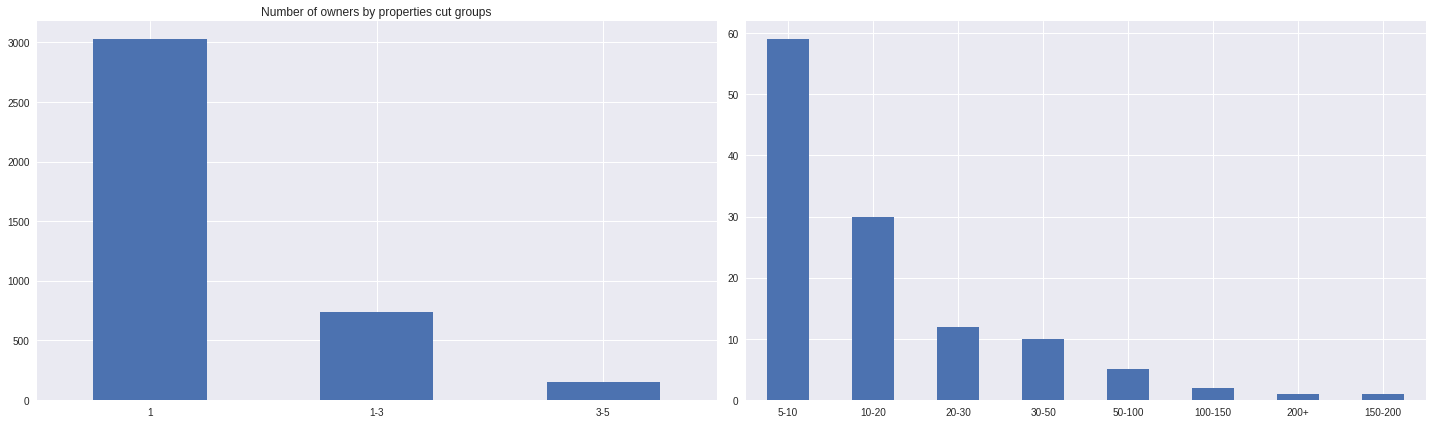

In [35]:
hosts = df.groupby('host_id')['id'].nunique().to_frame().reset_index().rename(columns={'id':'number_of_properties'})
bins = [0,1,3,5,10,20,30,50,100,150,200,230]
f_bins = list()
for x in range(1,len(bins)-1):
  if x == 1:
    f_bins.append(str(bins[1]))
  else:
    f_bins.append(f'{bins[x-1]}-{bins[x]}')

  if x == len(bins)-2:
    f_bins.append(str(bins[-2]) + '+')

hosts['group'] = pd.cut(hosts.number_of_properties,bins=bins,labels=f_bins)

fig,ax =plt.subplots(1,2,figsize=(20,6))
hosts.group.value_counts()[:3].plot.bar(rot=0,ax=ax.ravel()[0])
hosts.group.value_counts()[3:].plot.bar(rot=0,ax=ax.ravel()[1])
ax.ravel()[0].set_title('Number of owners by properties cut groups')
plt.tight_layout()

# Let's get into pricing

## Property Pricing

***Using the mean values filtered by basic property specs***

In [36]:
filtering_columns = ['neighbourhood','property_type','bathrooms',	'bedrooms',	'beds']
mean_prices_group = df.groupby(filtering_columns)['price'].mean().reset_index()

Now let's pick a random property and see the differences

In [57]:
smpl = df.sample(1).copy()
print('Sample specs')
print(smpl[filtering_columns + ['price']].T)
print('\nMean Price by same property specs')
print(smpl[filtering_columns].merge(mean_prices_group,on=filtering_columns,how='left').T)

Sample specs
                        583
neighbourhood  Lower Haight
property_type     Apartment
bathrooms                 2
bedrooms                  2
beds                      2
price                   216

Mean Price by same property specs
                          0
neighbourhood  Lower Haight
property_type     Apartment
bathrooms                 2
bedrooms                  2
beds                      2
price                 357.5


**XGBoost**

In [38]:
# columns for training
x_cols = ['property_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'number_of_reviews', 'review_scores_rating',
       'cancellation_policy', 'neighbourhood', 'availability_365'] 
# copy the main dataframe
xdf = df[x_cols + ['price']].copy()
# fill missing values
xdf.loc[(xdf.neighbourhood.isnull()) & (xdf.property_type == 'Boat'),'neighbourhood'] = 'Here is a boat'
xdf = xdf.fillna(0)

#label encoding
label_encoding = dict()
to_label = ['property_type','cancellation_policy','neighbourhood']
for x in to_label:
  l = xdf[x].unique()
  label_encoding[x] = dict(zip( l, list(range(len(l))) ))
  xdf[x] = xdf[x].map(label_encoding[x].get)
xdf[:3]

,property_type,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,cancellation_policy,neighbourhood,availability_365,price
0,0,3,1.0,1.0,2.0,1120.0,4200.0,100.0,100.0,241,97.0,0,0,143,170.0
1,0,5,1.0,2.0,3.0,1600.0,5500.0,0.0,100.0,111,98.0,1,1,0,235.0
2,0,2,4.0,1.0,1.0,485.0,1685.0,200.0,50.0,19,84.0,1,2,365,65.0


In [39]:
import xgboost as xgb

In [40]:
xgr = xgb.XGBRegressor(objective='reg:gamma').fit(xdf[x_cols],xdf['price'])

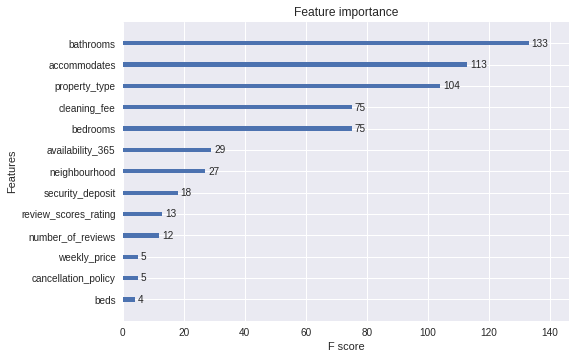

In [41]:
xgb.plot_importance(xgr)

In [42]:
smpl = xdf.sample(1).copy()
print('Sample specs')
print(smpl[x_cols + ['price']].T)
print(f'\nXGBoost Gamma Regressor Prediced Price {xgr.predict(smpl[x_cols])[0]}')

Sample specs
                       7587
property_type           0.0
accommodates            2.0
bathrooms               1.0
bedrooms                1.0
beds                    1.0
weekly_price            0.0
monthly_price           0.0
security_deposit      200.0
cleaning_fee          100.0
number_of_reviews       0.0
review_scores_rating    0.0
cancellation_policy     2.0
neighbourhood          43.0
availability_365       83.0
price                  86.0

XGBoost Gamma Regressor Prediced Price 150.90704345703125


In [43]:
def predict_price(df,xgr):
  c_df = df.copy()
  for j in to_label:
    c_df[j] = c_df[j].map(label_encoding[j].get)
  return xgr.predict(c_df)

## Portfolio Simulations

Estimate number of nights per year for each listing

Source:
[tule2236/Airbnb-Dynamic-Pricing-Optimization](https://github.com/tule2236/Airbnb-Dynamic-Pricing-Optimization)

> As found in the Overview of the Airbnb Community in San Francisco published by Airbnb, the average length of stay per guest is 4.2 nights. We assumed each listing has 4.2 days as an average lengths of stay per booking. Since we were not able to find a clear number for the ratio of guests making a booking who leave a review for Airbnb, we assumed the review rate to be equal to 0.5, which will be used as a constant throughout the estimation. To prevent artificially high results, we also assumed the maximum occupancy rate cannot exceed 0.95, meaning even the busiest of listings will have several nights a month in which they go unrented. With these assumptions and constants, we generated the formulation of estimated occupancy rate shown below:

![](https://user-images.githubusercontent.com/30711638/48401720-c3bc2c80-e6f7-11e8-84e7-82cd1dbe25dd.png)

In [44]:
def estimate_nights_per_year(review_per_month,yearly_availability):
  av_nights = 4.2
  review_rate = 0.5
  max_occupancy_rate = 0.95
  bookings_per_month = review_per_month / review_rate
  est_occupancy = min( (( bookings_per_month * av_nights ) / 30),max_occupancy_rate)
  return est_occupancy * yearly_availability

In [45]:
df['estimated_nights_per_year'] = df.apply(lambda x :  estimate_nights_per_year(x.number_of_reviews,x.availability_365),axis=1)

**Average estimated nights per year by neighbourhood and property type**

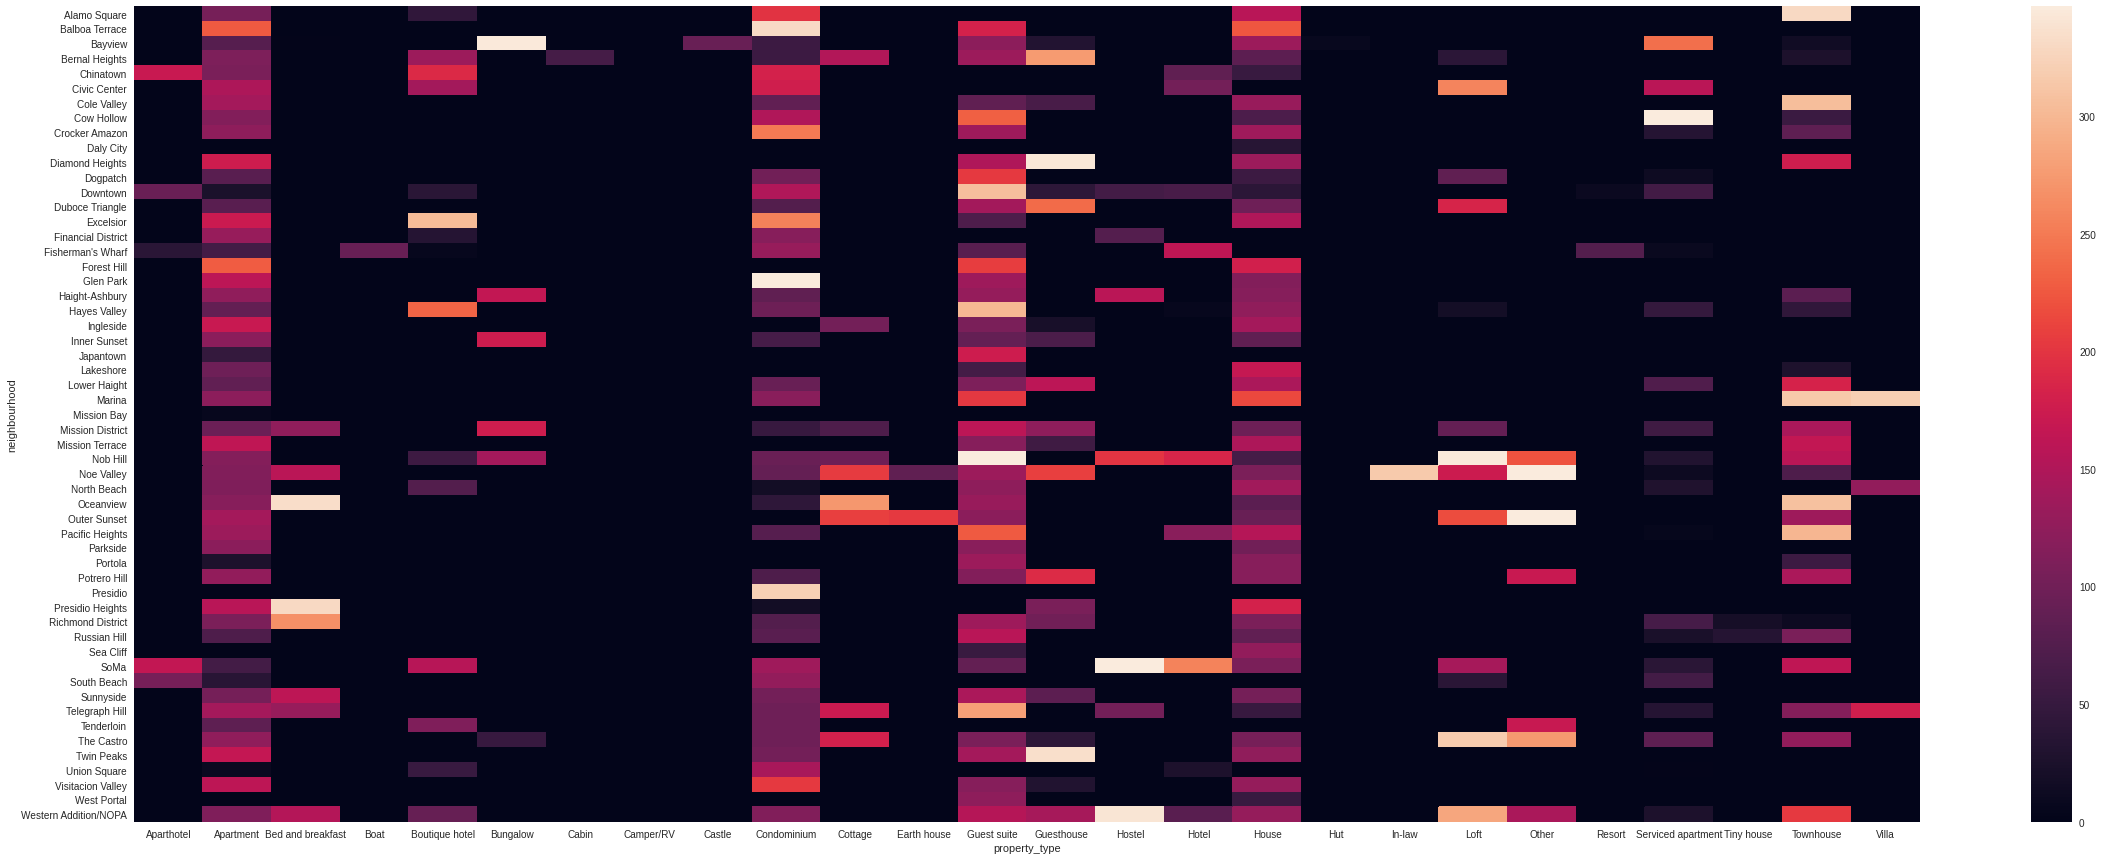

In [55]:
plt.figure(figsize=(40,15))
sns.heatmap(df.pivot_table(index='neighbourhood',columns='property_type',values='estimated_nights_per_year',aggfunc='mean',fill_value=0))

### Monte Carlo

Since we don't have property prices, we assume that after 20 years of activity, the property paid the price for itself.

![](https://captecwealthgroup.com/wp-content/uploads/2019/07/Property-portfolio-model.jpg)

#### 1 Month data

In [ ]:
main_columns = ['neighbourhood','property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds']
copy_df = df.copy()
# estimate number of nights per year
copy_df['estimated_nights_per_year'] = copy_df.apply(lambda x :  estimate_nights_per_year(x.number_of_reviews,x.availability_365),axis=1)
# get optimized prices
copy_df['optimized_price'] = predict_price(copy_df[x_cols],xgr)

# groupb by main columns
mdf = copy_df.groupby(main_columns).agg({
    'availability_365': 'mean',
    'price': ['mean','std'],
    'number_of_reviews':'mean',
    'estimated_nights_per_year':'mean',
    'optimized_price': ['mean','std']
}).reset_index().dropna()

# join multi-indexes together
mdf.columns = [ '_'.join(x) if x[1] != '' else x[0] for x in mdf.columns ]

# calculate return per year
mdf['estimated_return_per_year'] = mdf['price_mean'] * mdf['estimated_nights_per_year_mean']

# calculate optimized return  per year
mdf['estimated_optimized_return_per_year'] = mdf['optimized_price_mean'] * mdf['estimated_nights_per_year_mean']

# generate property price
mdf['estimated_property_price'] = mdf['price_mean'] * (365 * 20)

# format property price
mdf['estimated_property_price_M'] = (mdf['estimated_property_price'] / 1e6).map(lambda x: f'$ {x:.4f}')

mdf[:3]

,neighbourhood,property_type,accommodates,bathrooms,bedrooms,beds,availability_365_mean,price_mean,price_std,number_of_reviews_mean,estimated_nights_per_year_mean,optimized_price_mean,optimized_price_std,estimated_return_per_year,estimated_optimized_return_per_year,estimated_property_price,estimated_property_price_M
2,Alamo Square,Apartment,1,3.0,1.0,1.0,364.25,48.0,6.000000,3.25,86.6875,57.929253,4.668282,4161.00,5021.742087,350400.0,$ 0.3504
3,Alamo Square,Apartment,2,1.0,1.0,1.0,317.50,152.0,32.526912,26.50,128.2500,154.892731,17.912474,19494.00,19864.992714,1109600.0,$ 1.1096
6,Alamo Square,Apartment,4,1.0,1.0,2.0,159.50,150.0,98.994949,9.50,151.5250,166.732971,5.983315,22728.75,25264.213460,1095000.0,$ 1.0950



**Portfolios**

In [ ]:
# 10M $ to invest
investment = 1e7

mc_portfolios = list()
pmax=100
for p in range(pmax):
    print(f'{p}/{pmax}',end='\r')

    #while we have money, pick up random properties for portfolio
    local_df = mdf.copy()

    current_money = investment

    picked_properties = list()

    stop_flag = False

    while stop_flag != True:
      # pick up random property
      ch = local_df.sample(1).copy()
      # if we have money to buy it and we haven't already bought it then let's do it
      if ch.estimated_property_price.values[0] < current_money and ch.index.values[0] not in picked_properties:
        # add property index to current portfolio list of properties
        picked_properties.append(ch.index.values[0])
        # pay the property price
        current_money -= ch.estimated_property_price.values[0]
        # slice the current dataframe to get just affordable properties
        local_df = local_df[local_df.estimated_property_price < current_money]
      # if we dont't have enough money to buy the event the cheapest property or we run out of properties then it's the time to stop
      if current_money < local_df.estimated_property_price.min() or len(local_df) < 1:
        stop_flag = True
      

    tmp_portfolio = mdf[mdf.index.isin(picked_properties)].copy()
    tmp_portfolio['mdf_id'] = picked_properties
    tmp_portfolio['p'] = p
    mc_portfolios.append(tmp_portfolio)

mc_portfolios = pd.concat(mc_portfolios).reset_index(drop=True)
mc_portfolios[:2]

,neighbourhood,property_type,accommodates,bathrooms,bedrooms,beds,availability_365_mean,price_mean,price_std,number_of_reviews_mean,estimated_nights_per_year_mean,optimized_price_mean,optimized_price_std,estimated_return_per_year,estimated_optimized_return_per_year,estimated_property_price,estimated_property_price_M,mdf_id,p
0,Bernal Heights,Condominium,4,1.5,2.0,2.0,17.5,244.50,106.773124,50.50,16.625,245.411896,0.479673,4064.8125,4079.972767,1784850.0,$ 1.7849,2726,0
1,Chinatown,Apartment,1,1.5,1.0,1.0,349.5,65.25,13.817260,2.75,240.510,92.636261,2.107101,15693.2775,22279.947130,476325.0,$ 0.4763,187,0


In [ ]:
portfolio_results = mc_portfolios.groupby('p').agg({
    'estimated_return_per_year': 'sum',
    'estimated_property_price': 'sum',
    'estimated_optimized_return_per_year': 'sum',
    'mdf_id': 'count',
}).reset_index()

portfolio_results['estimated_property_price_M'] = (portfolio_results['estimated_property_price'] / 1e6).map(lambda x: f'$ {x:.4f}')
portfolio_results['estimated_return_per_year_M'] = (portfolio_results['estimated_return_per_year'] / 1e6).map(lambda x: f'$ {x:.4f}')
portfolio_results['estimated_optimized_return_per_year_M'] = (portfolio_results['estimated_optimized_return_per_year'] / 1e6).map(lambda x: f'$ {x:.4f}')

portfolio_results['time_to_return'] = portfolio_results['estimated_property_price'] /  portfolio_results['estimated_return_per_year'] 
portfolio_results['time_to_return_optimized'] = portfolio_results['estimated_property_price'] /  portfolio_results['estimated_optimized_return_per_year'] 

portfolio_results['profit'] = (portfolio_results['time_to_return'] * portfolio_results['estimated_optimized_return_per_year']) - (portfolio_results['time_to_return'] * portfolio_results['estimated_return_per_year'])
portfolio_results['profit_of_investment'] = portfolio_results['profit'] / portfolio_results['estimated_property_price']
portfolio_results['profit_M'] = (portfolio_results['profit'] / 1e6).map(lambda x: f'$ {x:.4f}')

**Portfolios with minimal return time**

In [ ]:
portfolio_results.sort_values(by='time_to_return_optimized',ascending=True)[:3]

,p,estimated_return_per_year,estimated_property_price,estimated_optimized_return_per_year,mdf_id,estimated_property_price_M,estimated_return_per_year_M,estimated_optimized_return_per_year_M,time_to_return,time_to_return_optimized,profit,profit_of_investment,profit_M
39,39,222350.258407,9.966736e+06,339534.248750,13,$ 9.9667,$ 0.2224,$ 0.3395,44.824486,29.354140,5.252712e+06,0.527024,$ 5.2527
66,66,219921.792321,9.931917e+06,309218.686489,7,$ 9.9319,$ 0.2199,$ 0.3092,45.161129,32.119393,4.032749e+06,0.406039,$ 4.0327
35,35,189177.550040,9.990919e+06,296431.938938,8,$ 9.9909,$ 0.1892,$ 0.2964,52.812393,33.703922,5.664361e+06,0.566951,$ 5.6644


**Time is money**

Profit vs Time to return


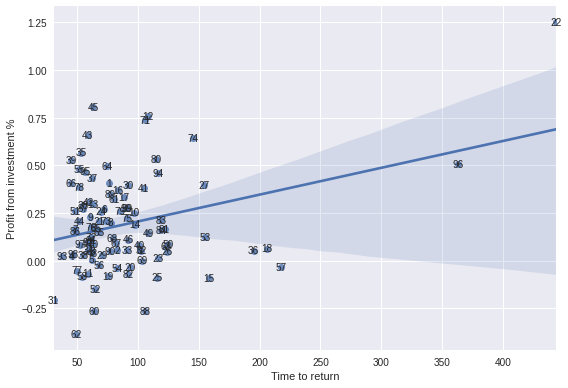

In [ ]:
sns.regplot(portfolio_results['time_to_return'],portfolio_results['profit_of_investment'])

for x in portfolio_results.itertuples():
  plt.annotate(x.p,(x.time_to_return, x.profit_of_investment),ha='center',va='center')

plt.xlabel('Time to return')
plt.ylabel('Profit from investment %')
plt.tight_layout()

**Portfolios by time and profit**

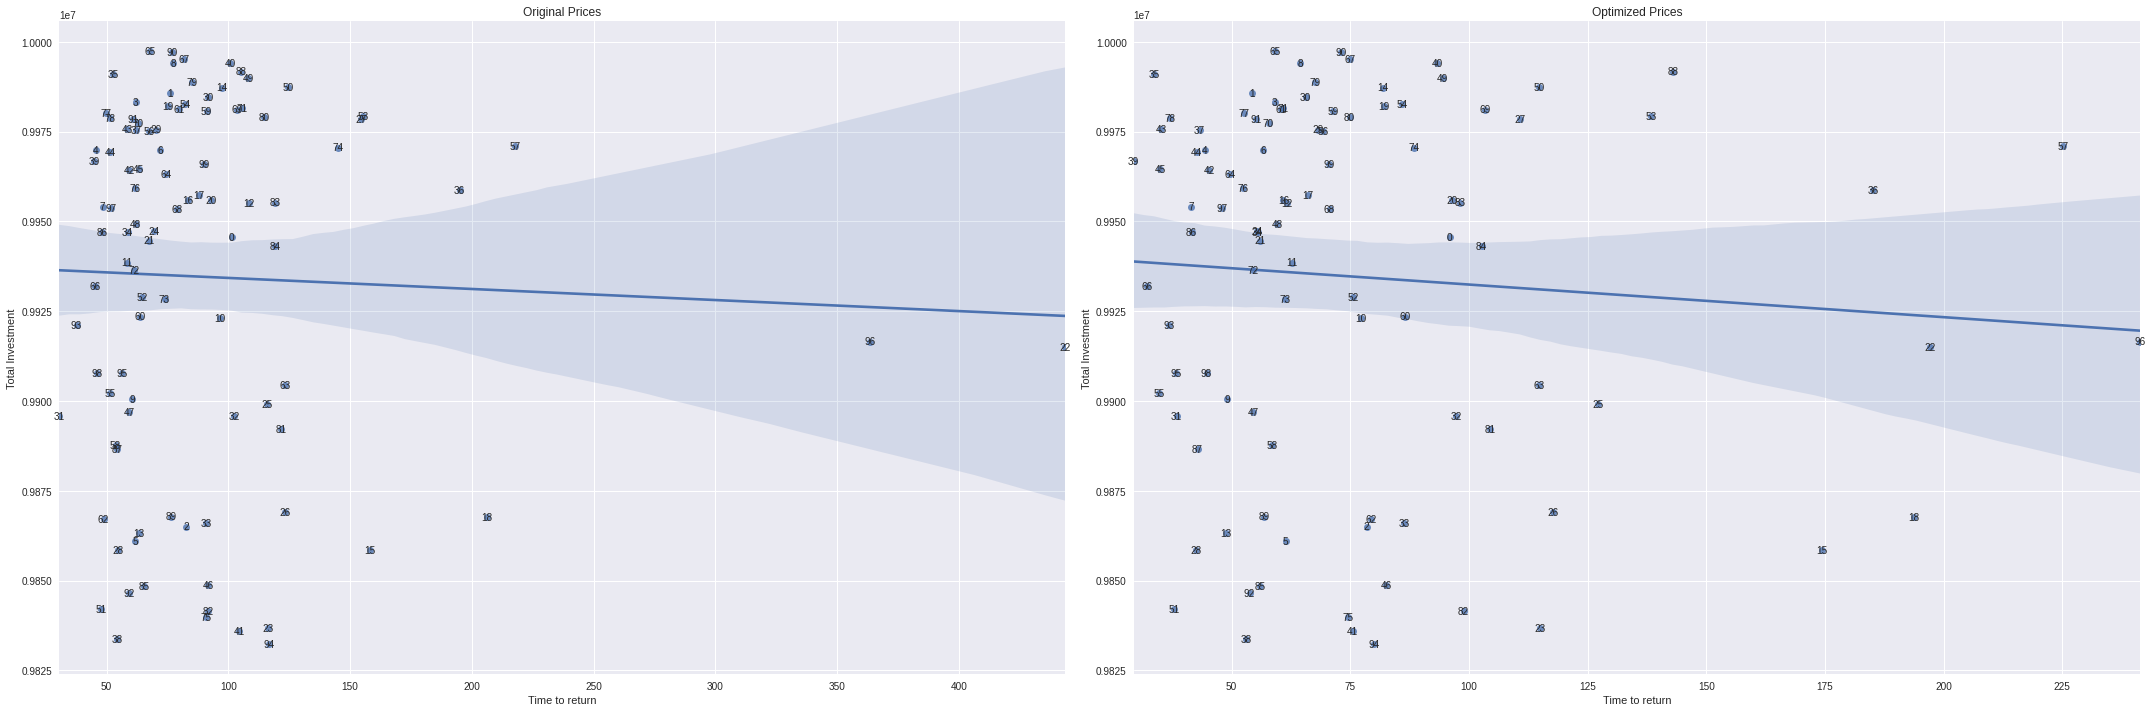

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(30,10))

sns.regplot(portfolio_results['time_to_return'],portfolio_results['estimated_property_price'],ax=ax[0])

sns.regplot(portfolio_results['time_to_return_optimized'],portfolio_results['estimated_property_price'],ax=ax[1])

for x in portfolio_results.itertuples():
  ax[0].annotate(x.p,(x.time_to_return, x.estimated_property_price),ha='center',va='center')
  ax[1].annotate(x.p,(x.time_to_return_optimized, x.estimated_property_price),ha='center',va='center')


ax[0].set_xlabel('Time to return')
ax[0].set_ylabel('Total Investment')
ax[0].set_title('Original Prices')
ax[1].set_xlabel('Time to return')
ax[1].set_ylabel('Total Investment')
ax[1].set_title('Optimized Prices')
plt.tight_layout()

**Portfolios by yearly return and total investment**

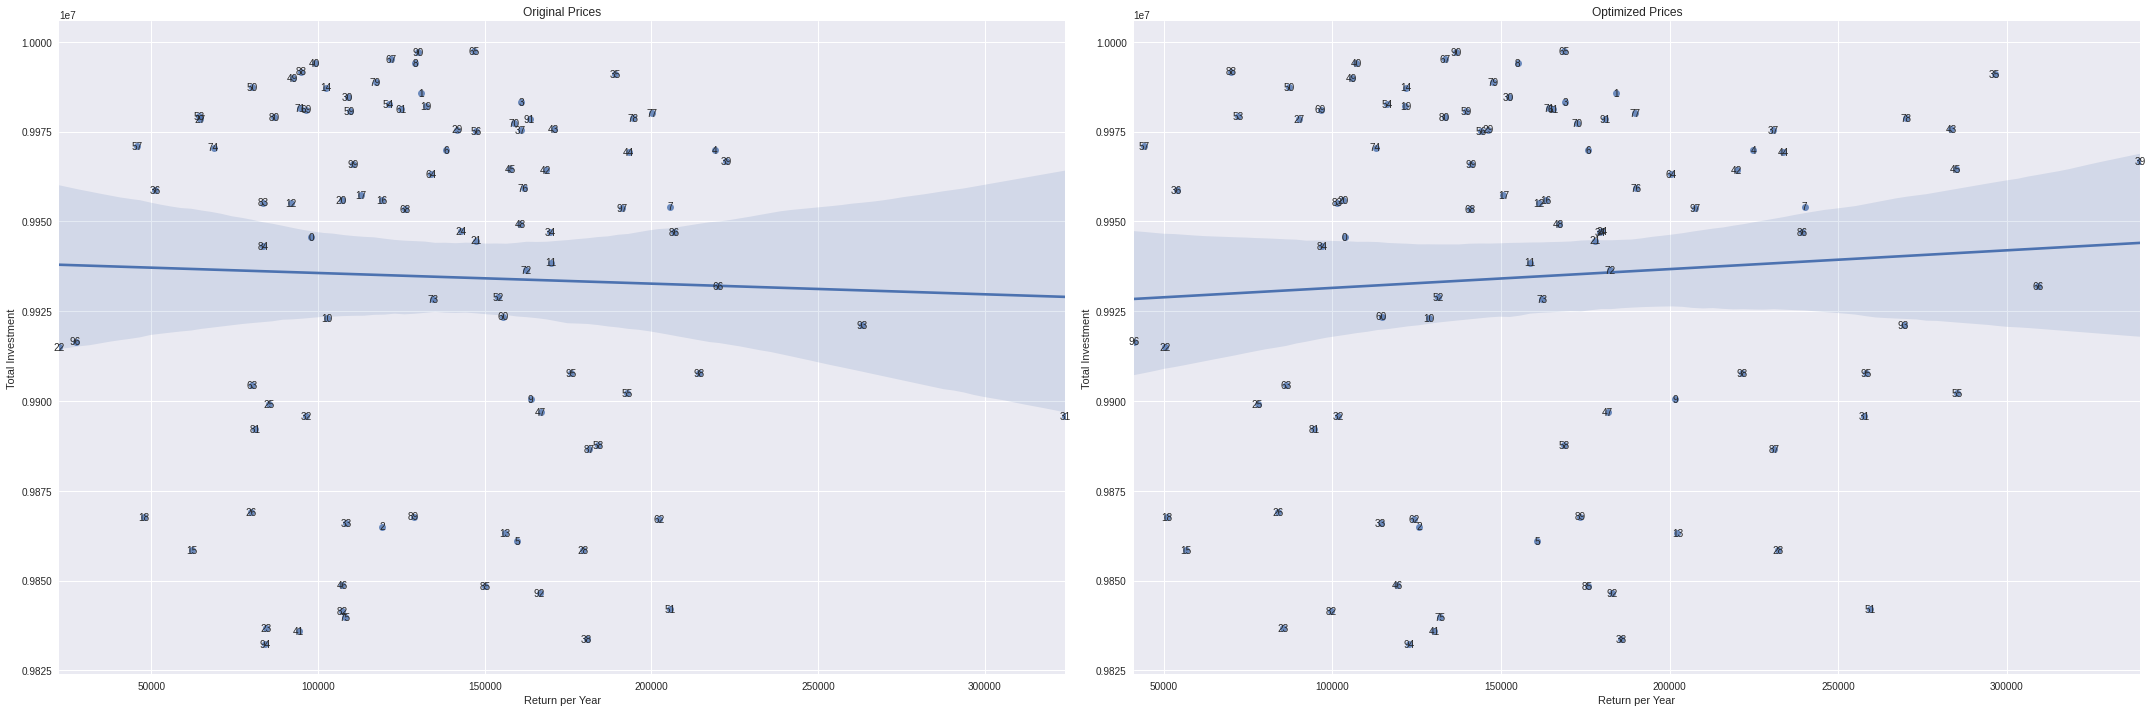

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(30,10))

sns.regplot(portfolio_results['estimated_return_per_year'],portfolio_results['estimated_property_price'],ax=ax[0])

sns.regplot(portfolio_results['estimated_optimized_return_per_year'],portfolio_results['estimated_property_price'],ax=ax[1])

for x in portfolio_results.itertuples():
  ax[0].annotate(x.p,(x.estimated_return_per_year, x.estimated_property_price),ha='center',va='center')
  ax[1].annotate(x.p,(x.estimated_optimized_return_per_year, x.estimated_property_price),ha='center',va='center')


ax[0].set_xlabel('Return per Year')
ax[0].set_ylabel('Total Investment')
ax[0].set_title('Original Prices')
ax[1].set_xlabel('Return per Year')
ax[1].set_ylabel('Total Investment')
ax[1].set_title('Optimized Prices')
plt.tight_layout()

#### 1 year data

In [ ]:
grp = dfs.groupby('id').agg({
    'host_id':'first',
    'neighbourhood':'first',
    'property_type':'first',
    'accommodates': 'mean',
    'bathrooms':'mean',
    'bedrooms': 'mean',
    'beds':'mean',
    'price':'mean',
    'number_of_reviews':'mean',
    'availability_365':'mean',
    'review_scores_rating': 'mean', 
    'monthly_price': 'mean', 
    'security_deposit': 'mean', 
    'cleaning_fee': 'mean', 
    'cancellation_policy': 'first', 
    'weekly_price': 'mean'
}).reset_index()
grp[:3]

,id,host_id,neighbourhood,property_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,availability_365,review_scores_rating,monthly_price,security_deposit,cleaning_fee,cancellation_policy,weekly_price
0,958,1169,Duboce Triangle,Apartment,3.0,1.0,1.0,2.0,170.0,224.769231,90.153846,97.000,4200.0,100.0,100.0,moderate,1120.0
1,3850,4921,Inner Sunset,House,2.0,1.0,1.0,1.0,99.0,159.250000,66.250000,94.375,0.0,0.0,10.0,strict_14_with_grace_period,0.0
2,5858,8904,Bernal Heights,Apartment,5.0,1.0,2.0,3.0,235.0,111.000000,0.076923,98.000,5500.0,0.0,100.0,strict_14_with_grace_period,1600.0


**location group**

In [ ]:
main_columns = ['neighbourhood','property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds']
copy_df = grp.copy()
copy_df['estimated_nights_per_year'] = copy_df.apply(lambda x :  estimate_nights_per_year(x.number_of_reviews,x.availability_365),axis=1)
copy_df['optimized_price'] = predict_price(copy_df[x_cols],xgr)

mdf = copy_df.groupby(main_columns).agg({
    'availability_365': 'mean',
    'price': ['mean','std'],
    'number_of_reviews':'mean',
    'estimated_nights_per_year':['mean','std'],
    'optimized_price': ['mean','std']
}).reset_index().dropna()

mdf.columns = [ '_'.join(x) if x[1] != '' else x[0] for x in mdf.columns ]

returns = list()
optimized_returns = list()

for x in mdf.itertuples():
  # generate random number of nights using the mean and std of estimated nights per year
  random_nights = np.abs(np.random.normal(loc=x.estimated_nights_per_year_mean,scale=x.estimated_nights_per_year_std))
  # generate random prices with the size of the random nights
  random_prices = np.random.normal(loc=x.price_mean,scale=x.price_std,size=int(random_nights))
  # add the yearly return to our list
  returns.append(random_prices.sum())

  # for the same number of random nights, calculate the optimized yearly return
  random_optim_prices = np.random.normal(loc=x.optimized_price_mean,scale=x.optimized_price_std,size=int(random_nights))
  optimized_returns.append(random_optim_prices.sum())

mdf['estimated_return_per_year'] = returns

mdf['estimated_optimized_return_per_year'] = optimized_returns

mdf['estimated_property_price'] = mdf['price_mean'] * (365 * 20)

mdf['estimated_property_price_M'] = (mdf['estimated_property_price'] / 1e6).map(lambda x: f'$ {x:.4f}')

mdf[:3]

,neighbourhood,property_type,accommodates,bathrooms,bedrooms,beds,availability_365_mean,price_mean,price_std,number_of_reviews_mean,estimated_nights_per_year_mean,estimated_nights_per_year_std,optimized_price_mean,optimized_price_std,estimated_return_per_year,estimated_optimized_return_per_year,estimated_property_price,estimated_property_price_M
2,Alamo Square,Apartment,1.0,3.0,1.0,1.0,348.685897,47.000000,4.898979,2.191026,75.109436,127.222971,60.804733,4.177582,11603.875568,14897.434087,3.431000e+05,$ 0.3431
3,Alamo Square,Apartment,2.0,1.0,1.0,1.0,199.173789,135.333333,36.909800,13.307692,72.541026,125.644742,156.995514,13.179280,21458.311016,25192.637399,9.879333e+05,$ 0.9879
9,Alamo Square,Apartment,4.0,1.0,1.0,2.0,159.062500,156.250000,90.156115,9.375000,151.109375,213.700928,166.732971,5.983315,2647.978633,2840.720439,1.140625e+06,$ 1.1406


In [ ]:
# 10M $ to invest
investment = 1e7

mc_portfolios = list()
pmax=100
for p in range(pmax):
    print(f'{p}/{pmax}',end='\r')

    #while we have money, pick up random properties for portfolio
    local_df = mdf.copy()

    current_money = investment

    picked_properties = list()

    stop_flag = False

    while stop_flag != True:
      # pick up random property
      ch = local_df.sample(1).copy()
      # if we have money to buy it and we haven't already bought it then let's do it
      if ch.estimated_property_price.values[0] < current_money and ch.index.values[0] not in picked_properties:
        # add property index to current portfolio list of properties
        picked_properties.append(ch.index.values[0])
        # pay the property price
        current_money -= ch.estimated_property_price.values[0]
        # slice the current dataframe to get just affordable properties
        local_df = local_df[local_df.estimated_property_price < current_money]
      # if we dont't have enough money to buy even the cheapest property or we run out of properties then it's the time to stop
      if current_money < local_df.estimated_property_price.min() or len(local_df) < 1:
        stop_flag = True
      

    tmp_portfolio = mdf[mdf.index.isin(picked_properties)].copy()
    tmp_portfolio['mdf_id'] = picked_properties
    tmp_portfolio['p'] = p
    mc_portfolios.append(tmp_portfolio)

mc_portfolios = pd.concat(mc_portfolios).reset_index(drop=True)
mc_portfolios[:2]

,neighbourhood,property_type,accommodates,bathrooms,bedrooms,beds,availability_365_mean,price_mean,price_std,number_of_reviews_mean,estimated_nights_per_year_mean,estimated_nights_per_year_std,optimized_price_mean,optimized_price_std,estimated_return_per_year,estimated_optimized_return_per_year,estimated_property_price,estimated_property_price_M,mdf_id,p
0,Bayview,House,2.0,2.0,1.0,1.0,235.420994,84.28125,47.190994,3.540064,161.430898,111.271046,139.239120,19.414377,20207.811891,35149.639528,615253.125,$ 0.6153,2932,0
1,Bayview,House,8.0,3.0,4.0,4.0,25.307692,262.50000,53.033009,14.300000,24.042308,32.657455,549.040161,8.945264,10060.290051,21961.733177,1916250.000,$ 1.9163,213,0


In [ ]:
portfolio_results = mc_portfolios.groupby('p').agg({
    'estimated_return_per_year': 'sum',
    'estimated_property_price': 'sum',
    'estimated_optimized_return_per_year': 'sum',
    'mdf_id': 'count',
}).reset_index()

portfolio_results['estimated_property_price_M'] = (portfolio_results['estimated_property_price'] / 1e6).map(lambda x: f'$ {x:.4f}')
portfolio_results['estimated_return_per_year_M'] = (portfolio_results['estimated_return_per_year'] / 1e6).map(lambda x: f'$ {x:.4f}')
portfolio_results['estimated_optimized_return_per_year_M'] = (portfolio_results['estimated_optimized_return_per_year'] / 1e6).map(lambda x: f'$ {x:.4f}')

portfolio_results['time_to_return'] = portfolio_results['estimated_property_price'] /  portfolio_results['estimated_return_per_year'] 
portfolio_results['time_to_return_optimized'] = portfolio_results['estimated_property_price'] /  portfolio_results['estimated_optimized_return_per_year'] 


portfolio_results['profit'] = (portfolio_results['time_to_return'] * portfolio_results['estimated_optimized_return_per_year']) - (portfolio_results['time_to_return'] * portfolio_results['estimated_return_per_year'])
portfolio_results['profit_of_investment'] = portfolio_results['profit'] / portfolio_results['estimated_property_price']
portfolio_results['profit_M'] = (portfolio_results['profit'] / 1e6).map(lambda x: f'$ {x:.4f}')

**Portfolios with minimal return time**

In [ ]:
portfolio_results.sort_values(by='time_to_return_optimized',ascending=True)[:3]

,p,estimated_return_per_year,estimated_property_price,estimated_optimized_return_per_year,mdf_id,estimated_property_price_M,estimated_return_per_year_M,estimated_optimized_return_per_year_M,time_to_return,time_to_return_optimized,profit,profit_of_investment,profit_M
65,65,413167.932968,9.904386e+06,411843.015193,7,$ 9.9044,$ 0.4132,$ 0.4118,23.971816,24.048934,-3.176069e+04,-0.003207,$ -0.0318
20,20,199503.023973,9.993643e+06,348561.432544,10,$ 9.9936,$ 0.1995,$ 0.3486,50.092689,28.671109,7.466737e+06,0.747149,$ 7.4667
82,82,262761.351114,9.936821e+06,326939.359423,10,$ 9.9368,$ 0.2628,$ 0.3269,37.816904,30.393468,2.427014e+06,0.244244,$ 2.4270


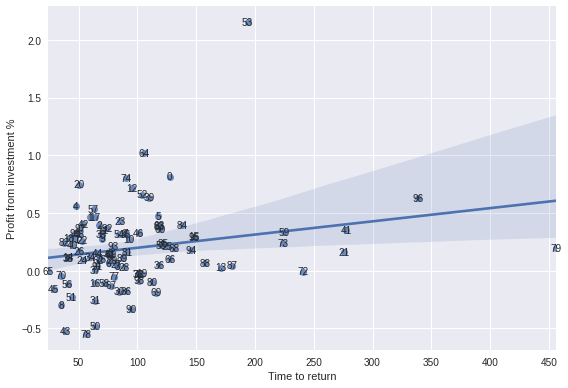

In [ ]:
sns.regplot(portfolio_results['time_to_return'],portfolio_results['profit_of_investment'])

for x in portfolio_results.itertuples():
  plt.annotate(x.p,(x.time_to_return, x.profit_of_investment),ha='center',va='center')

plt.xlabel('Time to return')
plt.ylabel('Profit from investment %')
plt.tight_layout()

**Portfolios by time to return and total investment**

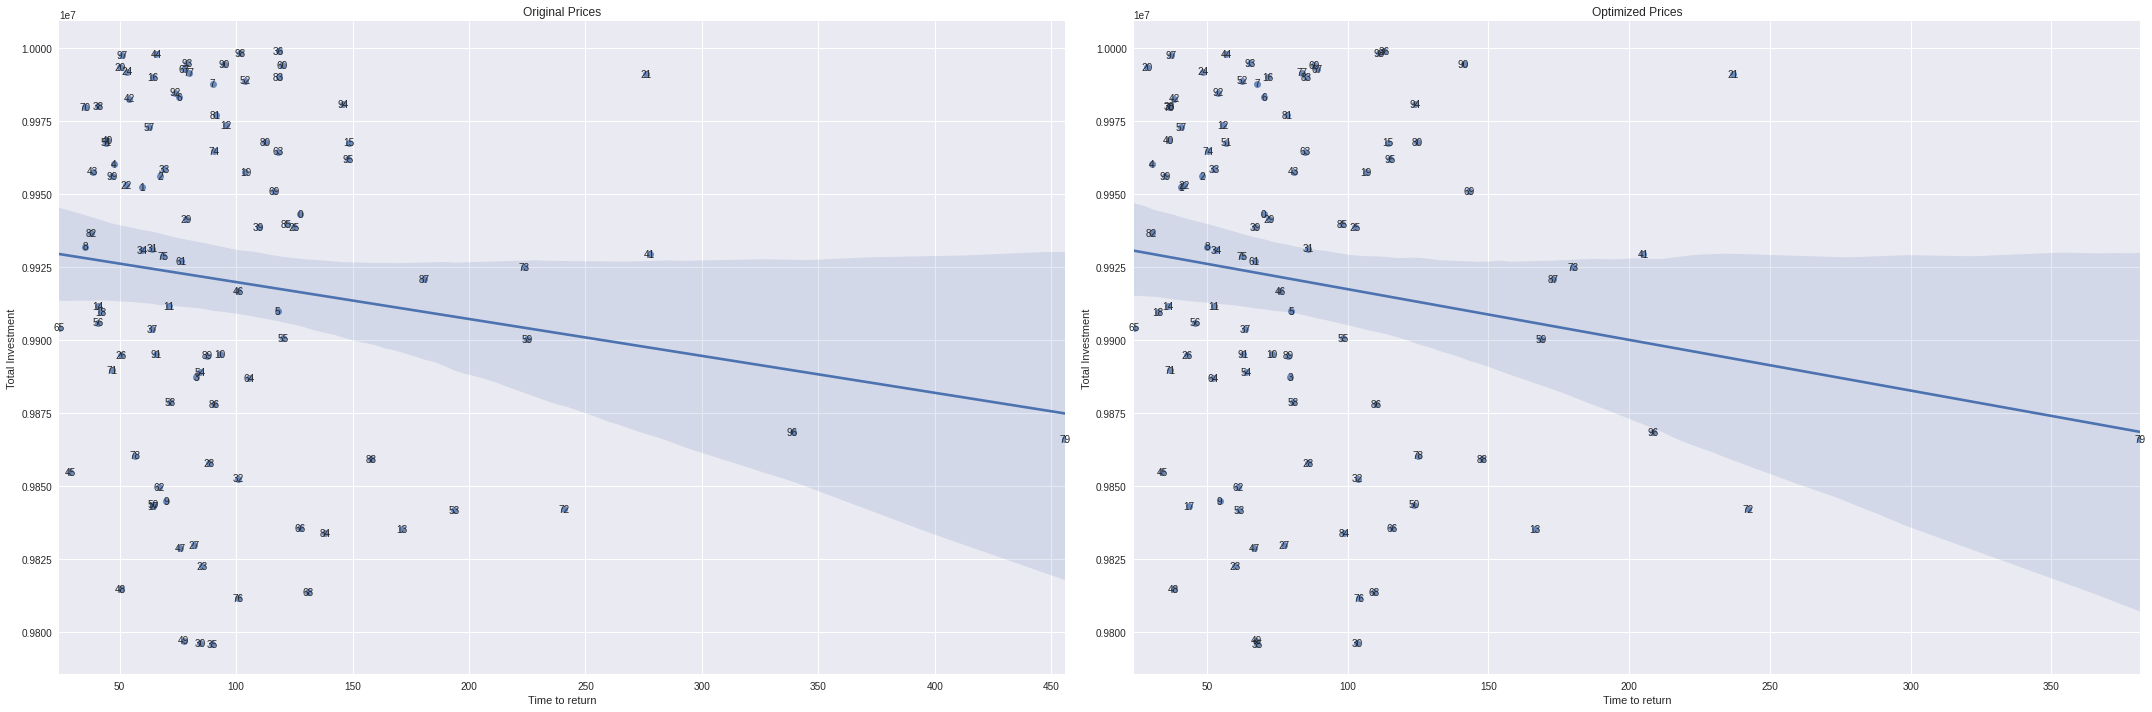

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(30,10))

sns.regplot(portfolio_results['time_to_return'],portfolio_results['estimated_property_price'],ax=ax[0])

sns.regplot(portfolio_results['time_to_return_optimized'],portfolio_results['estimated_property_price'],ax=ax[1])

for x in portfolio_results.itertuples():
  ax[0].annotate(x.p,(x.time_to_return, x.estimated_property_price),ha='center',va='center')
  ax[1].annotate(x.p,(x.time_to_return_optimized, x.estimated_property_price),ha='center',va='center')


ax[0].set_xlabel('Time to return')
ax[0].set_ylabel('Total Investment')
ax[0].set_title('Original Prices')
ax[1].set_xlabel('Time to return')
ax[1].set_ylabel('Total Investment')
ax[1].set_title('Optimized Prices')
plt.tight_layout()

**Huge return time**

Most probaby because there are some properties with just few days per year availability

In [ ]:
portfolio_results.sort_values(by='time_to_return_optimized',ascending=False)[:3]

,p,estimated_return_per_year,estimated_property_price,estimated_optimized_return_per_year,mdf_id,estimated_property_price_M,estimated_return_per_year_M,estimated_optimized_return_per_year_M,time_to_return,time_to_return_optimized,profit,profit_of_investment,profit_M
79,79,21630.442249,9.866244e+06,25863.355133,6,$ 9.8662,$ 0.0216,$ 0.0259,456.127712,381.475802,1.930749e+06,0.195692,$ 1.9307
72,72,40881.997953,9.842167e+06,40613.729134,8,$ 9.8422,$ 0.0409,$ 0.0406,240.745749,242.335965,-6.458458e+04,-0.006562,$ -0.0646
21,21,36208.247995,9.991117e+06,42171.958689,7,$ 9.9911,$ 0.0362,$ 0.0422,275.934828,236.913745,1.645595e+06,0.164706,$ 1.6456


**Portfolios by yearly return and total investment**

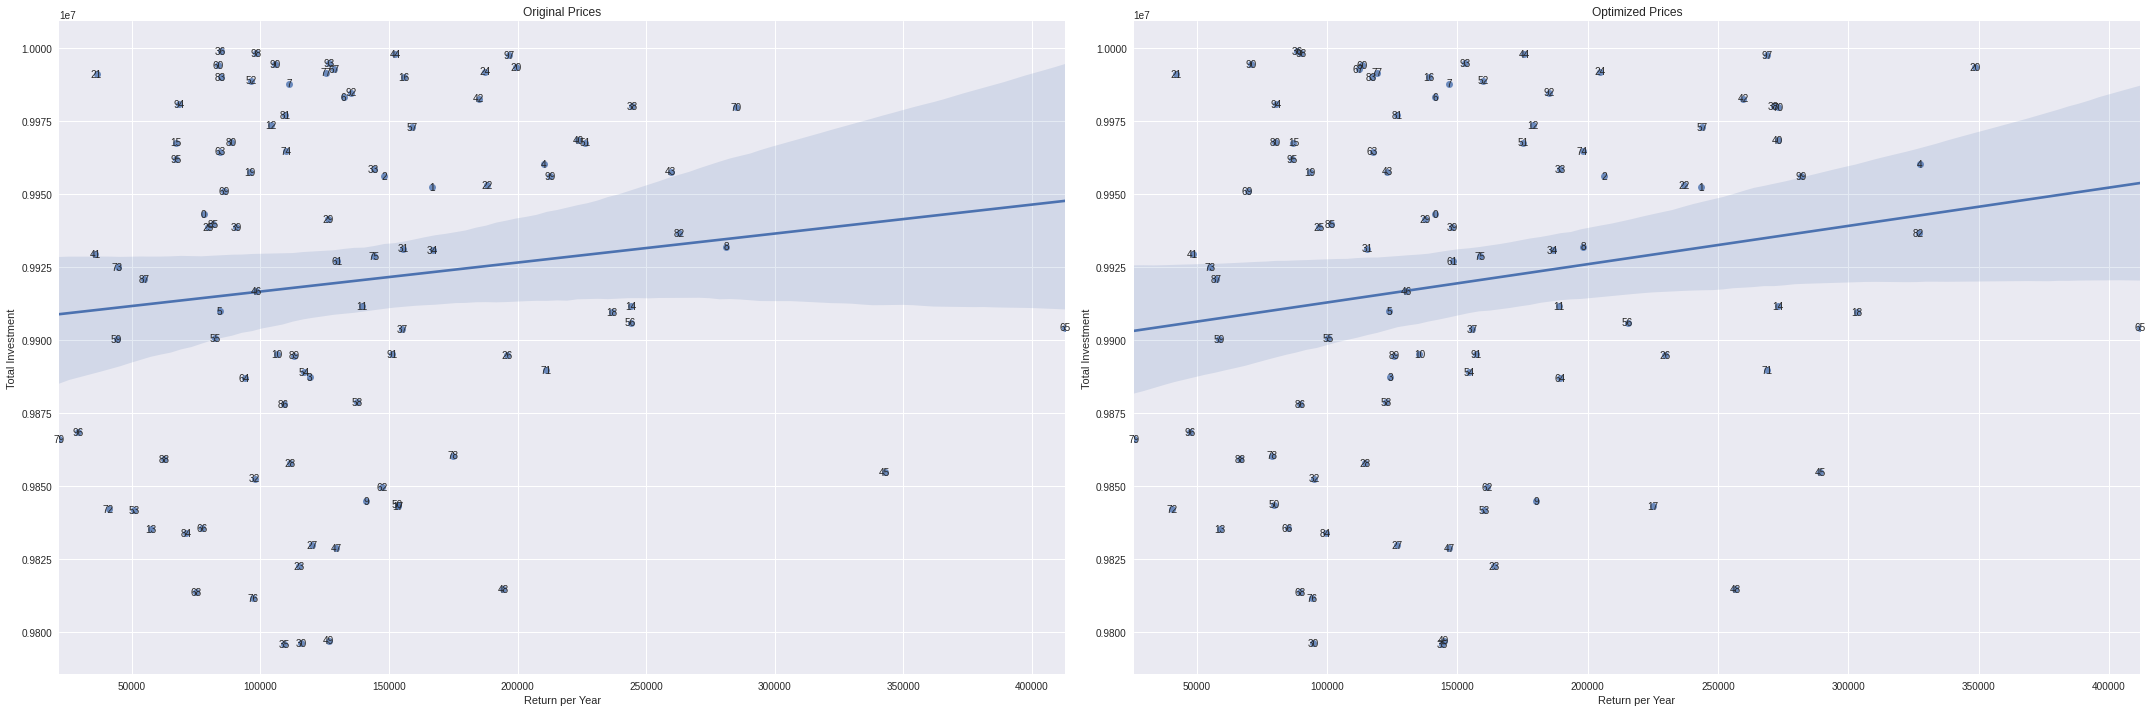

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(30,10))

sns.regplot(portfolio_results['estimated_return_per_year'],portfolio_results['estimated_property_price'],ax=ax[0])

sns.regplot(portfolio_results['estimated_optimized_return_per_year'],portfolio_results['estimated_property_price'],ax=ax[1])

for x in portfolio_results.itertuples():
  ax[0].annotate(x.p,(x.estimated_return_per_year, x.estimated_property_price),ha='center',va='center')
  ax[1].annotate(x.p,(x.estimated_optimized_return_per_year, x.estimated_property_price),ha='center',va='center')


ax[0].set_xlabel('Return per Year')
ax[0].set_ylabel('Total Investment')
ax[0].set_title('Original Prices')
ax[1].set_xlabel('Return per Year')
ax[1].set_ylabel('Total Investment')
ax[1].set_title('Optimized Prices')
plt.tight_layout()

## Next Iterations:
- Find External Data for properties prices
- Create a class for simulation
  - maybe more models
- Find a way to messure the predicted prices, if possible
- Maybe try binomial distribution to estimate number of nights per listing
- Fill the missing gaps:
 - more features for pricing model
 - more ways to estimate the number of nights per year
 - add risk rates



Sources:
- [bpostance/training.data_science](https://github.com/bpostance/training.data_science/blob/master/optimization/00-optimisation-monte-carlo-v0.0.ipynb)
- [dino-rodriguez/optibnb](https://github.com/dino-rodriguez/optibnb)
- [CarolineBarret/Modelling-Airbnb-Prices](https://github.com/CarolineBarret/Modelling-Airbnb-Prices)